# Grid world path optimization using artificial ant colony optimization (ACO)

## Importing modules

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Video

import functions as fn

## Parameters

In [2]:
# Paths
RESULTS_PATH = "./results"
ACO_RESULTS_PATH = f"{RESULTS_PATH}/ACO results"
ACO_VIDEO_PATH = f"{ACO_RESULTS_PATH}/ACO_results.mp4"

# Grid parameters
GRID_SIZE = (10, 15)
START_POSITION = (6, 1)
END_POSITION = (4, 13)
OBSTACLES = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14),
    (1, 0), (1, 14), (2, 0), (2, 5), (2, 6), (2, 11), (2, 14), (3, 0), (3, 11), (3, 14), (4, 0), (4, 9), (4, 10), (4, 11), (4, 14), 
    (5, 0), (5, 6), (5, 11), (5, 14), (6, 0), (6, 6), (6, 9), (6, 11), (6, 14), (7, 0), (7, 6), (7, 14), (8, 0), (8, 3), (8, 6), (8, 14), 
    (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14)
]
TRAPS = [(1, 3), (2, 3), (2, 7), (3, 3), (3, 10), (4, 3), (5, 3), (5, 13), (7, 9)]

# Simulation parameters
ALPHA = 2 
BETA = 3   
EVAPORATION_RATE = 0.5
DEPOSIT_FACTOR = 10      
NUM_ANTS = 1000
NUM_ITERATIONS = 1000
MAX_PATH_LENGTH = 32 
# MAX_PATH_LENGTH = float("inf") 
REVISIT_POSSIBLE = True
PHEROMONE_NORMALIZATION = True
DIRECTIONS = {
    "11": (-1, 0),  # Up
    "00": (1, 0),   # Down
    "01": (0, 1),   # Right
    "10": (0, -1)   # Left
}

# Visualization
WINDOW_SIZE = 10

# Other
RANDOM_STATE = 42
LINE = 100*'-'
DOUBLE_LINE = 100*'='
SIMULATION_STARTED = 36*'-' + " !!! SIMULATION STARTED !!! " + 36*'-'
SIMULATION_FINISHED = 36*'-' + " !!! SIMULATION FINISHED !!! " + 35*'-'

## Results directories creation

In [3]:
os.makedirs(RESULTS_PATH, exist_ok=True)
for directory in [ACO_RESULTS_PATH]:
    fn.create_or_empty_directory(directory)

## Grid world and pheromone initialization

In [4]:
initial_grid_world = fn.grid_world_creation(GRID_SIZE, START_POSITION, END_POSITION, OBSTACLES, TRAPS)
pheromones = np.ones(GRID_SIZE)

## Simulation

In [5]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

first_full_path = 0
full_path_counter = 0

best_paths = []
best_scores = []
median_scores = []
mean_scores = []
for iteration in range(1, NUM_ITERATIONS+1):
    all_paths = []
    full_paths = []
    for ant in range(NUM_ANTS):
        path = fn.ant_walk(
            start=START_POSITION,
            end=END_POSITION,
            pheromone=pheromones,
            grid_world=initial_grid_world,
            directions=DIRECTIONS,
            alpha=ALPHA,
            beta=BETA,
            max_path_length=MAX_PATH_LENGTH,
            revisit_possible=REVISIT_POSSIBLE,
            random_seed=RANDOM_STATE*iteration + ant**2
        )
        all_paths.append(path)
        
        if path[-1] == END_POSITION:
            if not first_full_path:
                first_full_path = iteration

            full_path_counter += 1
            full_paths.append(path)
    
    sorted_paths, sorted_indices = fn.sort_ant_paths(all_paths, END_POSITION)
    best_path = sorted_paths[0]
    best_paths.append(best_path)

    heuristic_scores = []
    for sorted_path in sorted_paths:
        heuristic_score = fn.calculate_heuristic_score(sorted_path[-1], END_POSITION)
        heuristic_scores.append(heuristic_score)

    best_score = heuristic_scores[0]
    median_score = round(np.median(np.array(heuristic_scores)),4)
    mean_score = round(np.mean(np.array(heuristic_scores)), 4)

    best_scores.append(best_score)
    median_scores.append(median_score)
    mean_scores.append(mean_score)

    if len(full_paths):
        fn.update_pheromones(
            paths=full_paths, 
            pheromones=pheromones, 
            evaporation_rate=EVAPORATION_RATE, 
            deposit_factor=DEPOSIT_FACTOR,
            pheromone_normalization=PHEROMONE_NORMALIZATION
        )

    if iteration == 1 or iteration % 20 == 0 or iteration == NUM_ITERATIONS:
        print(f" {iteration}. iteration finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        print(LINE)

if first_full_path:
    print(f"End position successfully reached in {first_full_path}. iteration.")
    print(f"Using {NUM_ITERATIONS} iterations with {NUM_ANTS} ants in each of it path is successfully completed in {full_path_counter} times.")
else:
    print("No full paths found.")

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. iteration finished - best score: 0.0 - median score: 11.4018 - mean score: 9.5224
----------------------------------------------------------------------------------------------------
 20. iteration finished - best score: 0.0 - median score: 0.0 - mean score: 0.0
----------------------------------------------------------------------------------------------------
 40. iteration finished - best score: 0.0 - median score: 0.0 - mean score: 0.0
----------------------------------------------------------------------------------------------------
 60. iteration finished - best score: 0.0 - median score: 0.0 - mean score: 0.0
----------------------------------------------------------------------------------------------------
 80. iteration finished - best score: 0.0 - median score: 0.0 - mean score: 0.0
-----------------------------------------------------------------------------------------

## Visualization the final grid world with pheromone levels

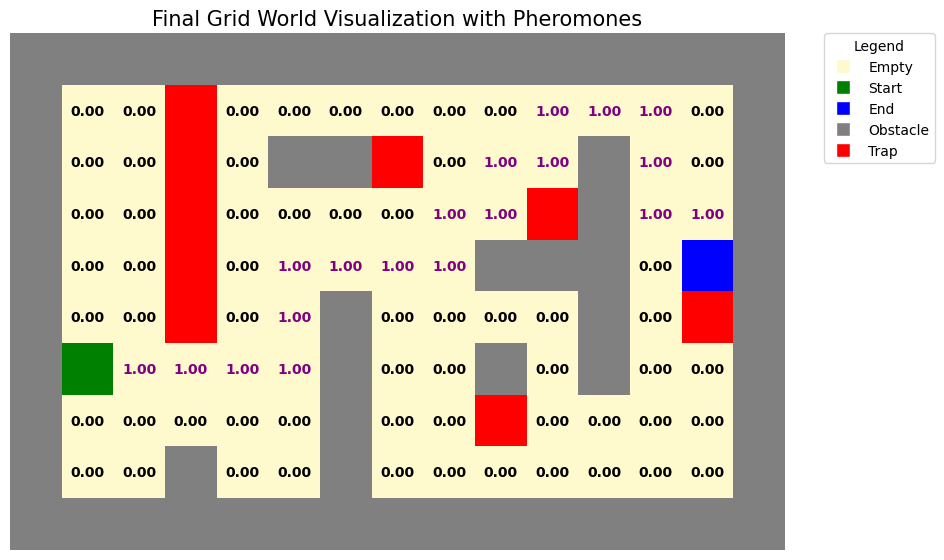

In [6]:
fn.grid_world_visualization(
    grid_world=initial_grid_world, 
    title="Final Grid World Visualization with Pheromones", 
    show_pheromones=pheromones
)

## Result scores visualization

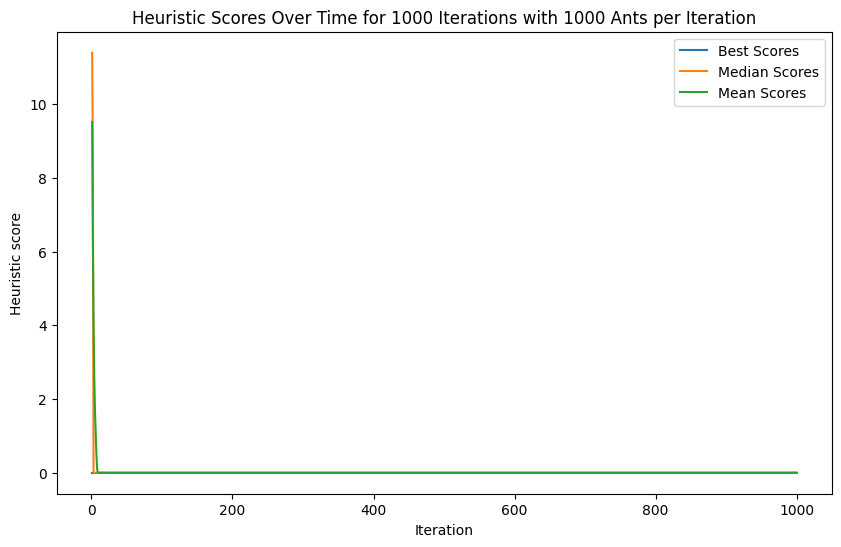

In [7]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title(f"Heuristic Scores Over Time for {NUM_ITERATIONS} Iterations with {NUM_ANTS} Ants per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Heuristic score")
plt.legend()

plt.show()

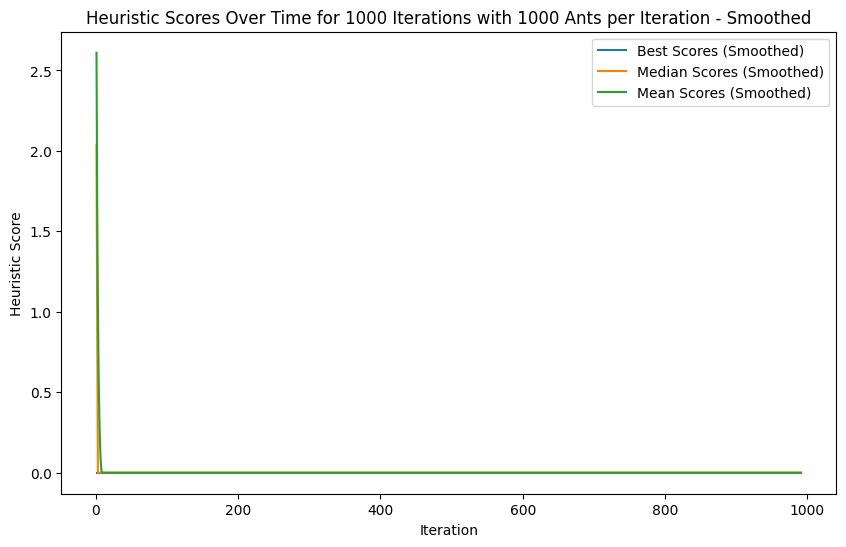

In [8]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title(f"Heuristic Scores Over Time for {NUM_ITERATIONS} Iterations with {NUM_ANTS} Ants per Iteration - Smoothed")
plt.xlabel("Iteration")
plt.ylabel("Heuristic Score")
plt.legend()

plt.show()


In [9]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruciton:")
fn.path_reconstruction(
    best_population_paths=best_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=ACO_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=int(iteration/10), 
    title_type="iteration", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(ACO_RESULTS_PATH, ACO_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruciton:


Processing generations/iterations: 100%|██████████| 11/11 [01:34<00:00,  8.55s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/ACO results/ACO_results.mp4
Video creation finished!


frame=  231 fps=220 q=-1.0 Lsize=     326kB time=00:00:45.60 bitrate=  58.5kbits/s speed=43.4x    
video:323kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.956799%
[libx264 @ 0x55cf4aa26bc0] frame I:1     Avg QP: 9.74  size: 24749
[libx264 @ 0x55cf4aa26bc0] frame P:153   Avg QP:16.50  size:  1759
[libx264 @ 0x55cf4aa26bc0] frame B:77    Avg QP:14.55  size:   466
[libx264 @ 0x55cf4aa26bc0] consecutive B-frames: 38.5% 45.9% 15.6%  0.0%
[libx264 @ 0x55cf4aa26bc0] mb I  I16..4: 81.7%  5.6% 12.7%
[libx264 @ 0x55cf4aa26bc0] mb P  I16..4:  1.4%  0.4%  0.7%  P16..4:  1.5%  0.2%  0.1%  0.0%  0.0%    skip:95.7%
[libx264 @ 0x55cf4aa26bc0] mb B  I16..4:  0.8%  0.2%  0.2%  B16..8:  1.8%  0.2%  0.0%  direct: 0.1%  skip:96.7%  L0:52.5% L1:46.7% BI: 0.8%
[libx264 @ 0x55cf4aa26bc0] 8x8 transform intra:15.0% inter:56.1%
[libx264 @ 0x55cf4aa26bc0] coded y,uvDC,uvAC intra: 13.2% 36.8% 29.5% inter: 0.5% 0.6% 0.5%
[libx264 @ 0x55cf4aa26bc0] i16 v,h,dc,p: 64% 34%  2%  0%
[li

In [10]:
Video(ACO_VIDEO_PATH, embed=True)